# Imports

In [391]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

pd.set_option("display.max_rows", None, "display.max_columns", None)
# pd.reset_option('all')

# Data Wrangling and Tidying
## Content:

**Input variables:**<br> 
1 - age (numeric) <br> 
2 - job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')<br> 
3 - marital : marital status (categorical: 'single', 'married', 'divorced', 'unknown')<br> 
4 - education (categorical: 'primary', 'secondary', 'tertiary', 'unknown')<br> 
5 - default: has credit in default? (categorical: 'no', 'yes', 'unknown')<br> 
6 - housing: has housing loan? (categorical: 'no', 'yes', 'unknown')<br> 
7 - loan: has personal loan? (categorical: 'no', 'yes', 'unknown')<br>

**Related with the last contact of the current campaign:**<br> 
8 - contact: contact communication type (categorical: 'cellular', 'telephone')<br> 
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')<br> 

**Other attributes:**<br> 
11 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br> 
12 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br> 
13 - previous: number of contacts performed before this campaign and for this client (numeric)<br> 
14 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br> 

**Output variable (desired target):**<br> 
15 - term_deposit - has the client subscribed a term deposit? (binary: 'yes','no')<br> 

In [392]:
df = pd.read_csv('data/bank.csv')

df['job'] = df['job'].map({'unknown': np.nan, 'student': 0, 'unemployed': 1, 'management': 2, 'technician': 3, 
                           'entrepreneur': 4, 'blue-collar': 5, 'admin.': 6, 'services': 7, 'self-employed': 8,  
                           'housemaid': 9, 'retired': 10})

df['marital'] = df['marital'].map({'unknown': np.nan, 'single': 0, 'married': 1, 'divorced': 2})

df['education'] = df['education'].map({'unknown': np.nan, 'primary': 1, 'secondary': 2, 'tertiary': 3})

df['default'] = df['default'].map({'no': 0, 'yes': 1})

df['housing'] = df['housing'].map({'no': 0, 'yes': 1})

df['loan'] = df['loan'].map({'no': 0, 'yes': 1})

df['contact'] = df['contact'].map({'unknown': np.nan, 'cellular': 1, 'telephone': 2})

df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
                               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})

df['poutcome'] = df['poutcome'].map({'unknown': np.nan, 'failure': 0, 'success': 1, 'other': 2})

df['term_deposit'] = df['term_deposit'].map({'no': 0, 'yes': 1})
    
df = df.dropna()
df = df.drop(['balance', 'duration', 'day'], axis=1)

anomaly_detector = NearestNeighbors(n_neighbors = 3)
anomaly_detector.fit(df)

distances, indexes = anomaly_detector.kneighbors(df)

# plt.plot(distances.mean(axis = 1))

df = df[~df.index.isin(np.where(distances.mean(axis = 1) > 15)[0])].reset_index(drop=True)

# print(df)

# Creating pivot datasets of age, marital, job and education

In [393]:
df_age = df.groupby(['term_deposit', 'age']).count().reset_index()
df_age = df_age[['term_deposit', 'age', 'marital']].rename(columns={'marital': 'amount'})
df_age_pivot = df_age.pivot(columns='term_deposit', index='age', values='amount').fillna(0)
# print(df_age_pivot)

df_marital = df.groupby(['term_deposit', 'marital']).count().reset_index()
df_marital = df_marital[['term_deposit', 'marital', 'age']].rename(columns={'age': 'amount'})
df_marital_pivot = df_marital.pivot(columns='term_deposit', index='marital', values='amount')
# print(df_marital_pivot)

df_job = df.groupby(['term_deposit', 'job']).count().reset_index()
df_job = df_job[['term_deposit', 'job', 'age']].rename(columns={'age': 'amount'})
df_job_pivot = df_job.pivot(columns='term_deposit', index='job', values='amount')
# print(df_job_pivot)

df_education = df.groupby(['term_deposit', 'education']).count().reset_index()
df_education = df_education[['term_deposit', 'education', 'age']].rename(columns={'age': 'amount'})
df_education_pivot = df_education.pivot(columns='term_deposit', index='education', values='amount')
# print(df_education_pivot)

# Creating dataset of percents and visualising

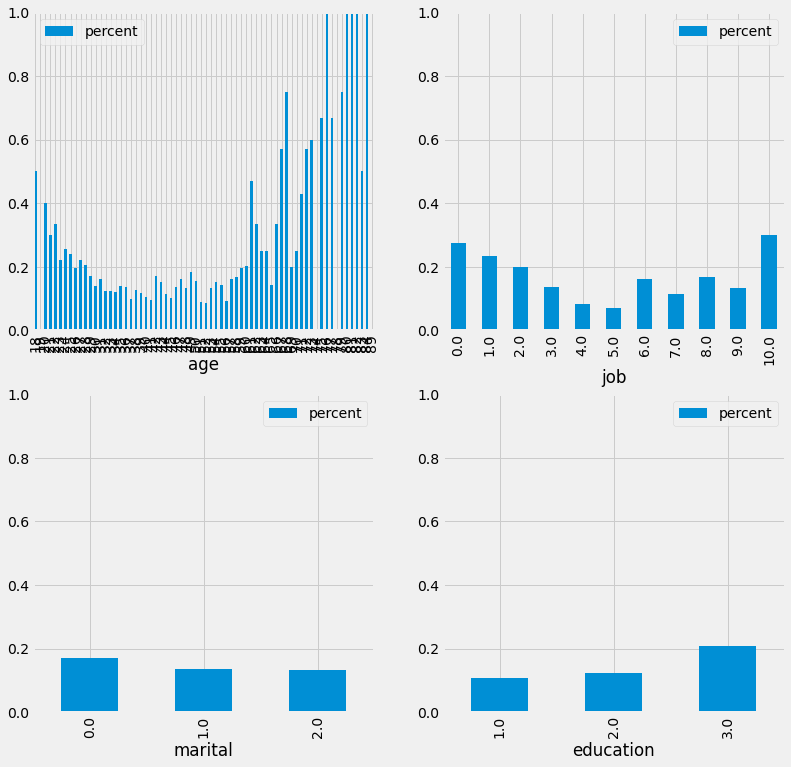

In [394]:
df_age_percent = (df_age_pivot[1] / (df_age_pivot[0] + df_age_pivot[1])).reset_index()
df_job_percent = (df_job_pivot[1] / (df_job_pivot[0] + df_job_pivot[1])).reset_index()
df_marital_percent = (df_marital_pivot[1] / (df_marital_pivot[0] + df_marital_pivot[1])).reset_index()
df_education_percent = (df_education_pivot[1] / (df_education_pivot[0] + df_education_pivot[1])).reset_index()

df_age_percent.set_axis(['age', 'percent'], axis=1, inplace=True)
df_job_percent.set_axis(['job', 'percent'], axis=1, inplace=True)
df_marital_percent.set_axis(['marital', 'percent'], axis=1, inplace=True)
df_education_percent.set_axis(['education', 'percent'], axis=1, inplace=True)

fig_percent, axes_percent = plt.subplots(nrows=2, ncols=2, figsize=(12,12))


df_age_percent.plot.bar(ax=axes_percent[0,0], x='age', y='percent', ylim=[0.0, 1.0])
df_job_percent.plot.bar(ax=axes_percent[0,1], x='job', y='percent', ylim=[0.0, 1.0])
df_marital_percent.plot.bar(ax=axes_percent[1,0], x='marital', y='percent', ylim=[0.0, 1.0])
df_education_percent.plot.bar(ax=axes_percent[1,1], x='education', y='percent', ylim=[0.0, 1.0])

plt.show()

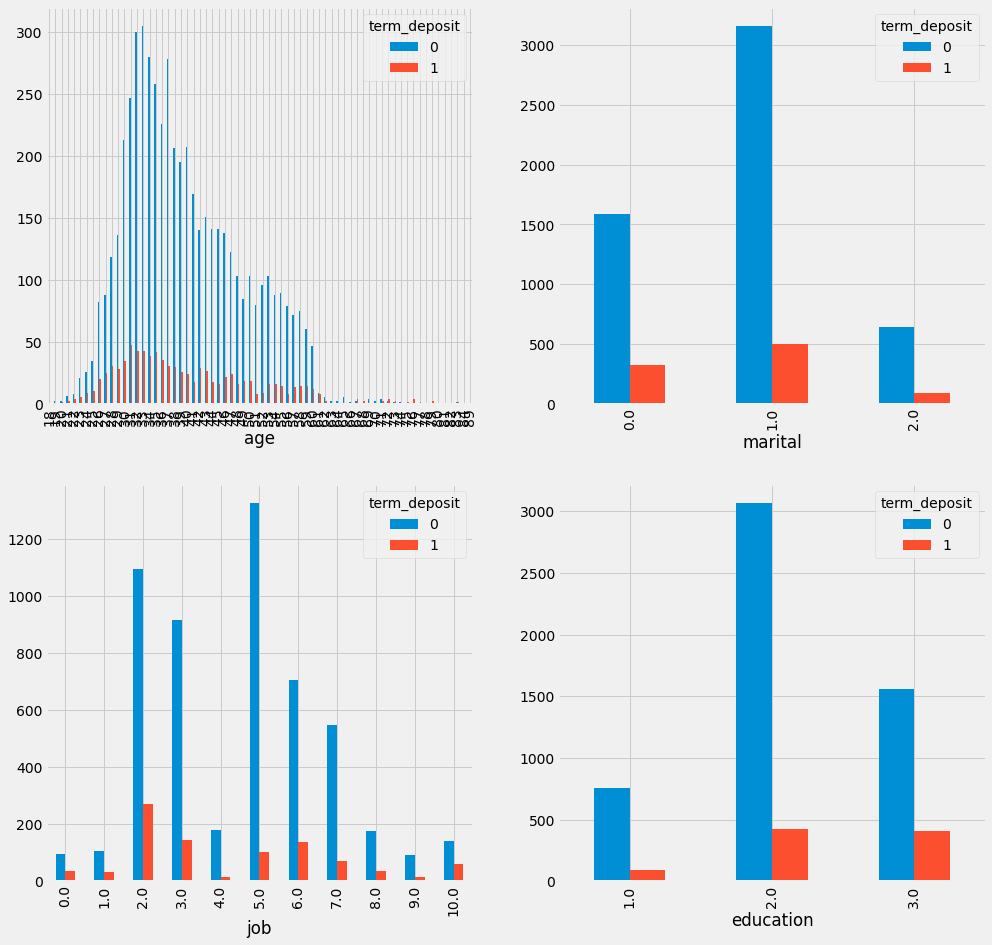

In [395]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

df_age_pivot.plot(ax=axes[0,0], kind='bar', figsize=(15, 15))
df_marital_pivot.plot(ax=axes[0,1], kind='bar', figsize=(15,15))
df_job_pivot.plot(ax=axes[1,0], kind='bar', figsize=(15, 15))
df_education_pivot.plot(ax=axes[1,1], kind='bar', figsize=(15, 15))

plt.show()

# Model and accuracy

In [396]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=1)

features = list(df.columns)
features.remove('term_deposit')

x_train, x_test, y_train, y_test = train_test_split(df[features], df['term_deposit'], test_size=0.2)

clf = MLPClassifier(hidden_layer_sizes=(27, 27), random_state=1, max_iter=1000).fit(x_train, y_train)
clf.predict_proba(x_test)
predictions = clf.predict(x_test)
score = clf.score(x_test, y_test)

print('Accuracy: ', score)

Accuracy:  0.8424386381631037
